# ========================================================
# Full End-to-End Skin Melanoma Classification Pipeline
# Stage 1: 3-class DeiT-base
# Stage 2: Binary EfficientNet-B2 for melanoma in situ vs invasive
# Includes: weighted sampling, evaluation metrics, ensemble
# ========================================================

[/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04](http://)

# Setup Env & Importing necessary Libraries 

In [1]:
# !pip install shap pytorch-grad-cam

# # Install Captum once (if not already installed)
# !pip install -q captum
# !pip install grad-cam

# # Install torchcam once
# !pip install -q torchcam



In [2]:
# Import Libraries 

import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from torchvision import models
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from sklearn.metrics import accuracy_score
import cv2
import torchcam
from torchvision.utils import make_grid

In [3]:

# --------------------- Config ---------------------
SEED = 42
BATCH_SIZE = 16
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 40
IMG_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUTPUT_DIR = Path('/kaggle/working/outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_ROOT = Path('/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04')
LABELS_STAGE1 = ['nevus','melanoma_in_situ','melanoma_invasive']
LABELS_STAGE2 = ['melanoma_in_situ','melanoma_invasive']

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# Exploratory Data Analysis

In [44]:
base_path = r"/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04"

label_folders = {
    'melanoma_in_situ': os.path.join(base_path, "melanoma_in_situ"),
    'melanoma_invasive': os.path.join(base_path, "melanoma_invasive"),
    'nevus': os.path.join(base_path, "nevus")
}

data = []

for label, folder in label_folders.items():
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            data.append({
                'image_path': os.path.join(folder, file),
                'label': label
            })

df = pd.DataFrame(data)
print(df.head())
print(f"\nTotal Images: {len(df)}")


                                          image_path             label
0  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
1  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
2  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
3  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ
4  /kaggle/input/melanoma-balanced-resized-verion...  melanoma_in_situ

Total Images: 2447


### Class Distribution:

melanoma_in_situ: 850 images
melanoma_invasive: 797 images
nevus: 800 images


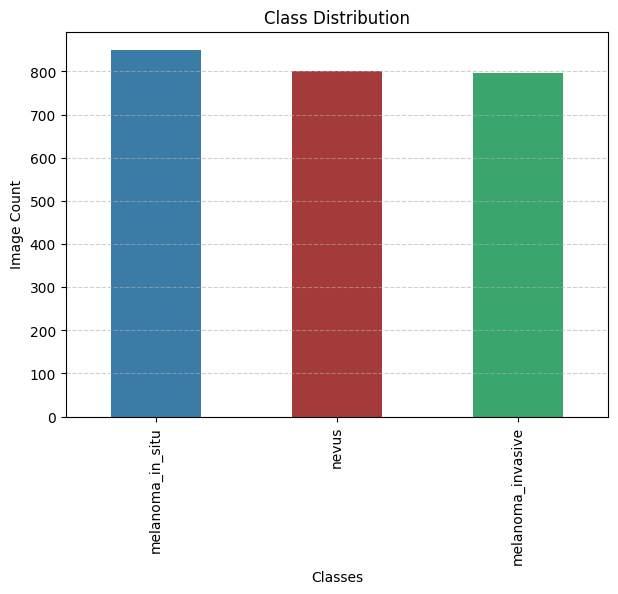

In [40]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random

# Dataset folders
# DATA_ROOT
folders = {
    "melanoma_in_situ": DATA_ROOT / "melanoma_in_situ",
    "melanoma_invasive": DATA_ROOT / "melanoma_invasive",
    "nevus": DATA_ROOT / "nevus"
}

# Collect image paths per class
image_paths = {cls: list(folder.glob("*")) for cls, folder in folders.items()}

# Count images per class
for cls, imgs in image_paths.items():
    print(f"{cls}: {len(imgs)} images")



plt.figure(figsize=(7,5))
df['label'].value_counts().plot(kind='bar', color=['#3A7CA5', '#A53A3A', '#3AA56D'])
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Image Dimensions & Aspect Ratio Analysis¶

100%|██████████| 2447/2447 [00:01<00:00, 1655.28it/s]


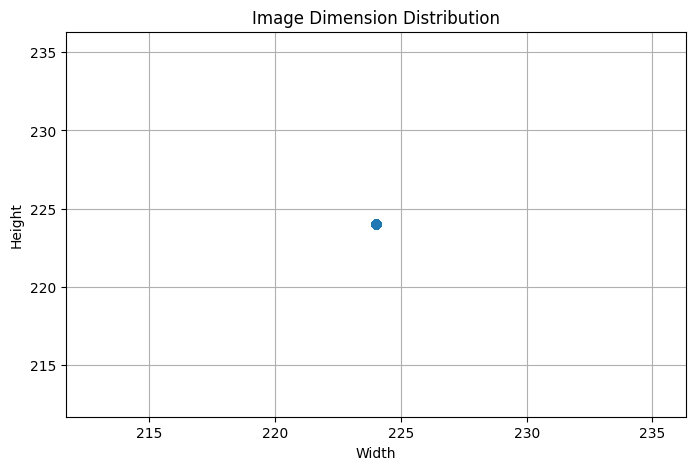

Unique image sizes: width  height
224    224       2447
Name: count, dtype: int64


In [41]:
dims = []
for path in tqdm(df['image_path']):
    img = Image.open(path)
    dims.append(img.size)  # (width, height)

df['width'], df['height'] = zip(*dims)

plt.figure(figsize=(8,5))
plt.scatter(df['width'], df['height'], alpha=0.3)
plt.title("Image Dimension Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()

print("Unique image sizes:", df[['width', 'height']].value_counts().head())


In [5]:

# --------------------- Dataset Class ---------------------
class SkinDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        label = row['label_idx']
        return img, int(label)


In [6]:

# --------------------- DataFrame Builder ---------------------
def build_dataframe(root: Path, labels: list):
    rows = []
    for label in labels:
        folder = root / label
        for p in folder.iterdir():
            if p.is_file() and p.suffix.lower() in ['.jpg','.jpeg','.png']:
                rows.append({'image_path': str(p), 'label': label})
    df = pd.DataFrame(rows)
    df['label_idx'] = df['label'].map({lbl:i for i,lbl in enumerate(labels)})
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df

### Random Samples per Class

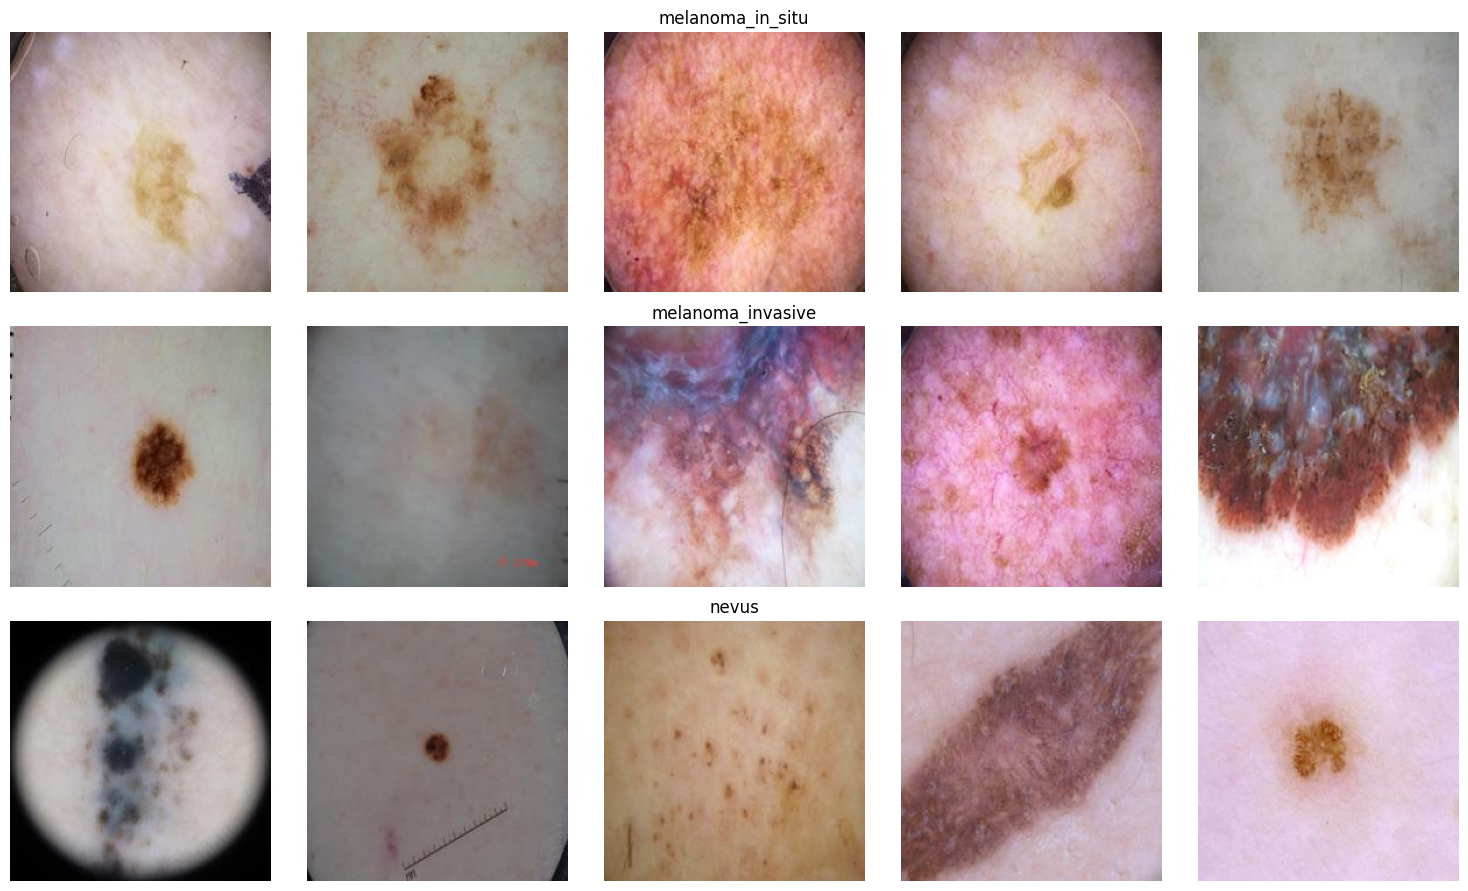

In [19]:
fig, axes = plt.subplots(len(folders), 5, figsize=(15,9))
for i, (cls, imgs) in enumerate(image_paths.items()):
    samples = random.sample(imgs, min(5, len(imgs)))
    for j, img_path in enumerate(samples):
        img = Image.open(img_path)
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
        if j == 2:
            axes[i,j].set_title(cls)
plt.tight_layout()
plt.show()


### Image Sizes & Aspect Ratios

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


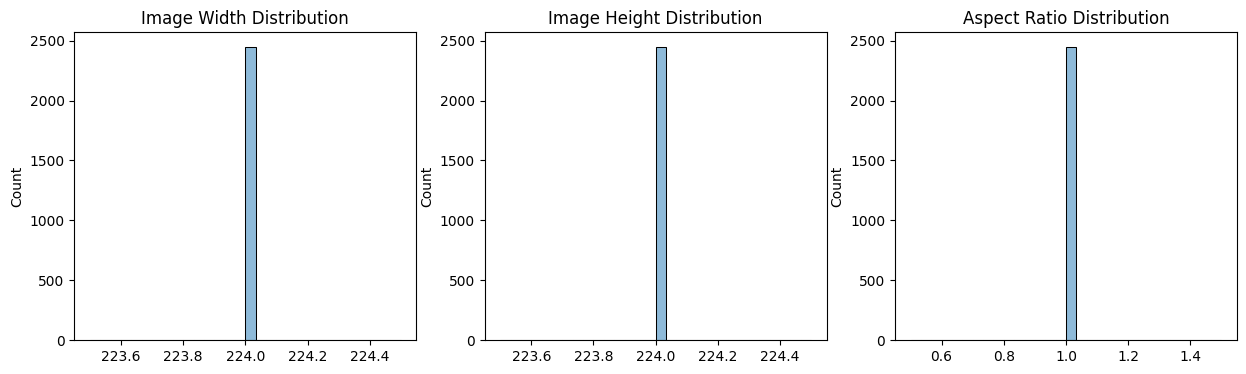

In [20]:
widths, heights, aspect_ratios = [], [], []

for imgs in image_paths.values():
    for img_path in imgs:
        img = Image.open(img_path)
        widths.append(img.width)
        heights.append(img.height)
        aspect_ratios.append(img.width/img.height)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.histplot(widths, bins=30, kde=True)
plt.title("Image Width Distribution")
plt.subplot(1,3,2)
sns.histplot(heights, bins=30, kde=True)
plt.title("Image Height Distribution")
plt.subplot(1,3,3)
sns.histplot(aspect_ratios, bins=30, kde=True)
plt.title("Aspect Ratio Distribution")
plt.show()


### Color Channel Analysis (RGB)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


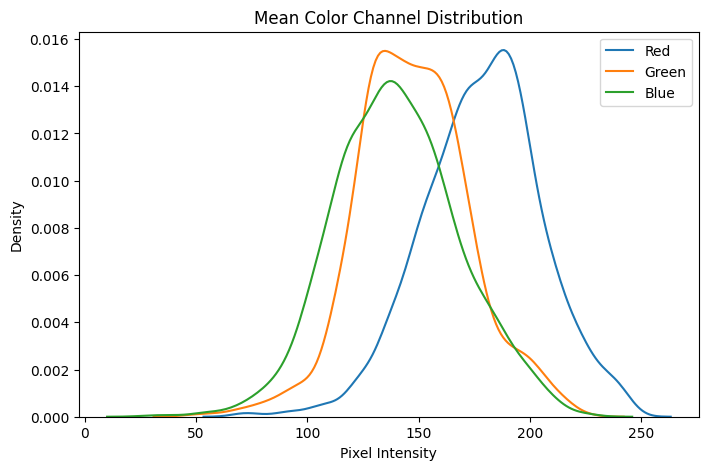

In [21]:
mean_r, mean_g, mean_b = [], [], []

for imgs in image_paths.values():
    for img_path in imgs[:1000]:  # sample first 1000 images for speed
        img = np.array(Image.open(img_path).convert("RGB"))
        mean_r.append(np.mean(img[:,:,0]))
        mean_g.append(np.mean(img[:,:,1]))
        mean_b.append(np.mean(img[:,:,2]))

plt.figure(figsize=(8,5))
sns.kdeplot(mean_r, label='Red')
sns.kdeplot(mean_g, label='Green')
sns.kdeplot(mean_b, label='Blue')
plt.title("Mean Color Channel Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()


### Brightness & Contrast Distribution

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


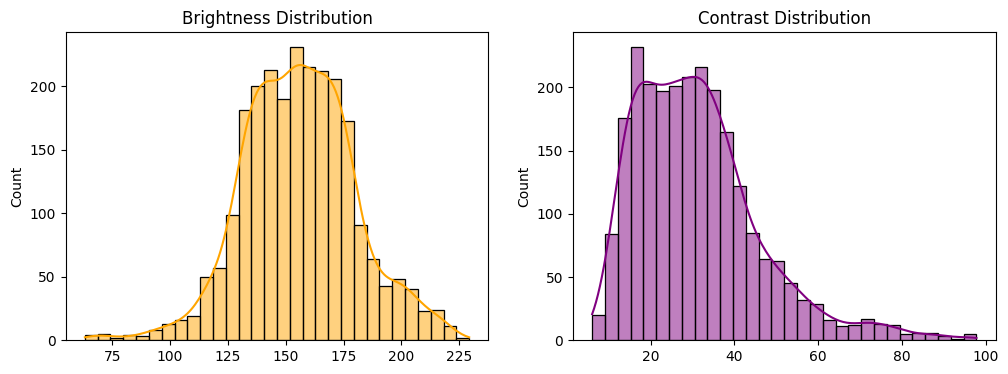

In [22]:
brightness, contrast = [], []

for imgs in image_paths.values():
    for img_path in imgs[:1000]:
        img = Image.open(img_path).convert("L")
        img_np = np.array(img)
        brightness.append(np.mean(img_np))
        contrast.append(np.std(img_np))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(brightness, bins=30, kde=True, color='orange')
plt.title("Brightness Distribution")
plt.subplot(1,2,2)
sns.histplot(contrast, bins=30, kde=True, color='purple')
plt.title("Contrast Distribution")
plt.show()


### Image Shape Heatmap 

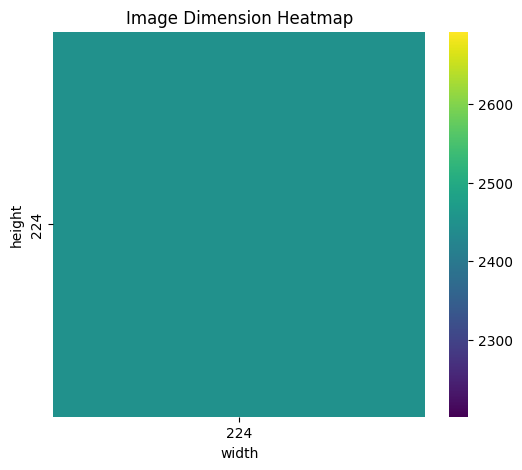

In [23]:
import pandas as pd

shape_df = pd.DataFrame({'width': widths, 'height': heights})
plt.figure(figsize=(6,5))
sns.heatmap(pd.crosstab(shape_df['height'], shape_df['width']), cmap='viridis')
plt.title("Image Dimension Heatmap")
plt.show()


### Class-wise Average Images

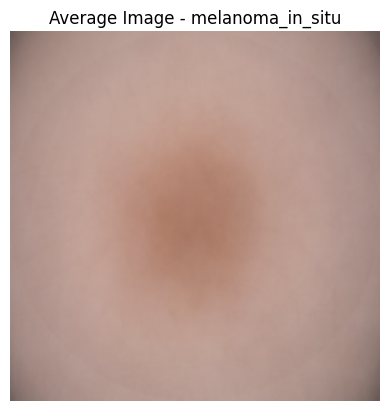

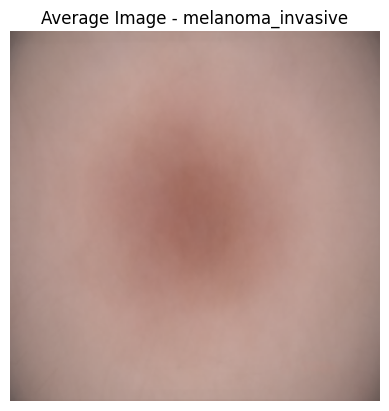

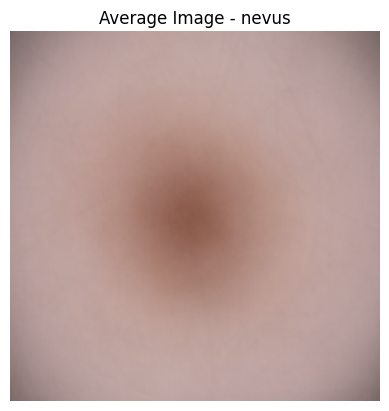

In [24]:
for cls, imgs in image_paths.items():
    avg_img = np.zeros((224,224,3))  # resize to 224x224 for averaging
    for img_path in imgs[:100]:  # sample 100 images
        img = Image.open(img_path).resize((224,224))
        avg_img += np.array(img)/100
    plt.imshow(avg_img.astype(np.uint8))
    plt.title(f"Average Image - {cls}")
    plt.axis('off')
    plt.show()


### Color Channel Analysis per Class

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

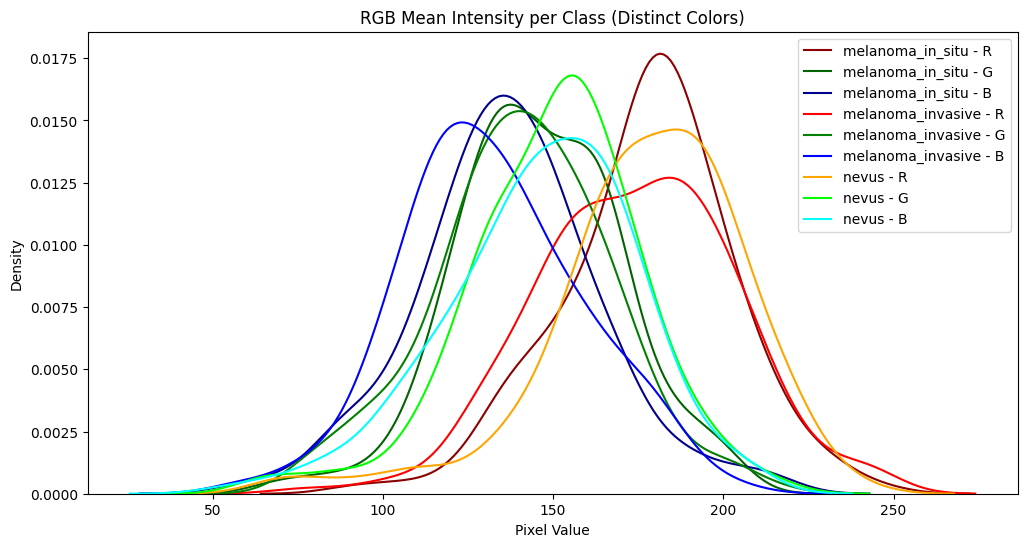

In [29]:
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Initialize dictionary
color_dict = {cls: {'R':[], 'G':[], 'B':[]} for cls in classes}

# Sample a subset per class (optional, for speed)
sample_size = 200  # or adjust depending on memory

for cls in classes:
    sample_imgs = random.sample(image_paths[cls], min(len(image_paths[cls]), sample_size))
    for img_path in sample_imgs:
        img = Image.open(img_path).convert("RGB").resize((224,224))  # Resize to reduce memory
        img_np = np.array(img)
        color_dict[cls]['R'].append(np.mean(img_np[:,:,0]))
        color_dict[cls]['G'].append(np.mean(img_np[:,:,1]))
        color_dict[cls]['B'].append(np.mean(img_np[:,:,2]))

# Assign unique colors per class and channel
class_colors = {
    'melanoma_in_situ': {'R':'darkred', 'G':'darkgreen', 'B':'darkblue'},
    'melanoma_invasive': {'R':'red', 'G':'green', 'B':'blue'},
    'nevus': {'R':'orange', 'G':'lime', 'B':'cyan'}
}

# Plot
plt.figure(figsize=(12,6))
for cls in classes:
    sns.kdeplot(color_dict[cls]['R'], label=f'{cls} - R', color=class_colors[cls]['R'])
    sns.kdeplot(color_dict[cls]['G'], label=f'{cls} - G', color=class_colors[cls]['G'])
    sns.kdeplot(color_dict[cls]['B'], label=f'{cls} - B', color=class_colors[cls]['B'])

plt.title("RGB Mean Intensity per Class (Distinct Colors)")
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.show()



### Edge/Texture Patterns per Class

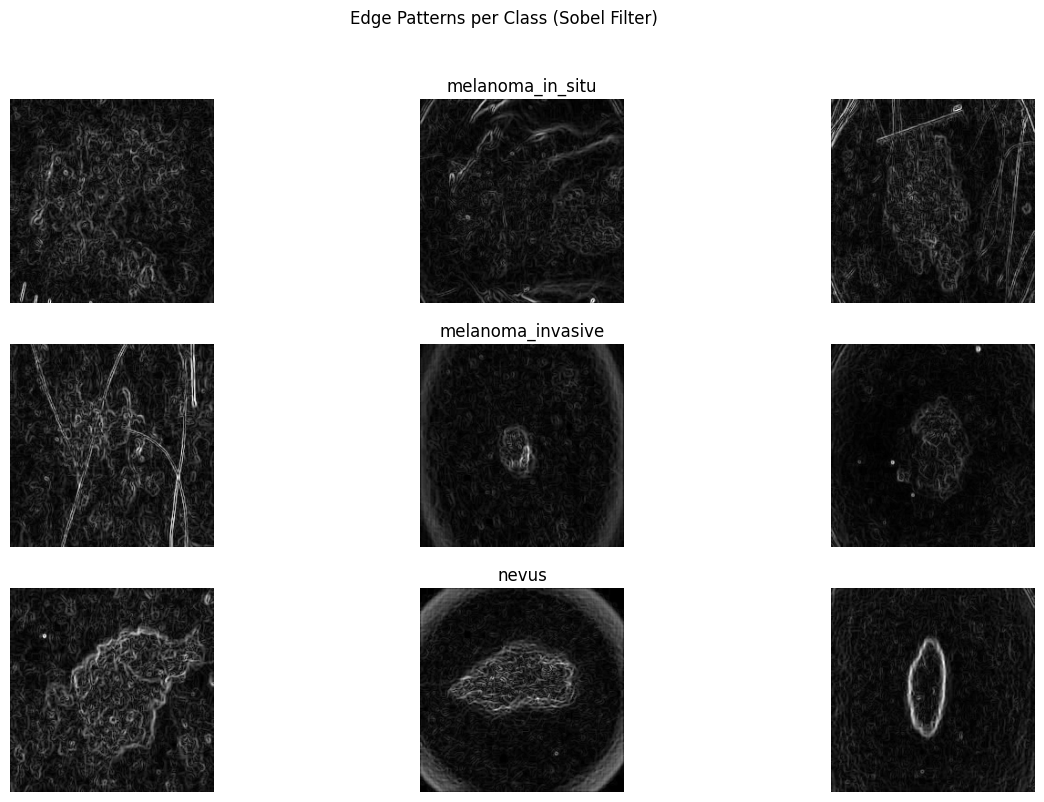

In [30]:
plt.figure(figsize=(15,9))
for i, cls in enumerate(classes):
    sample_imgs = random.sample(image_paths[cls], 3)
    for j, img_path in enumerate(sample_imgs):
        img = np.array(Image.open(img_path).convert("L").resize((224,224)))
        edge = sobel(img)
        plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(edge, cmap='gray')
        if j==1:
            plt.title(cls)
        plt.axis('off')
plt.suptitle("Edge Patterns per Class (Sobel Filter)")
plt.show()


### Pixel Intensity Heatmaps

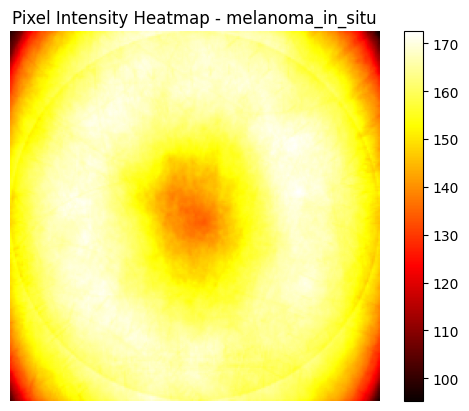

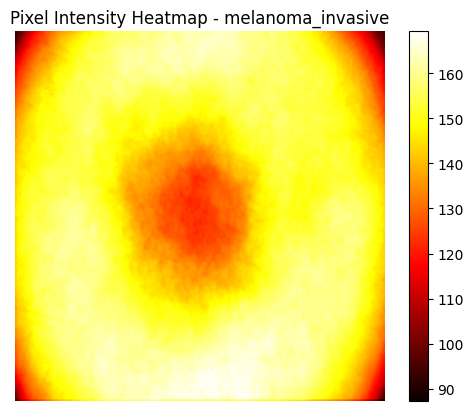

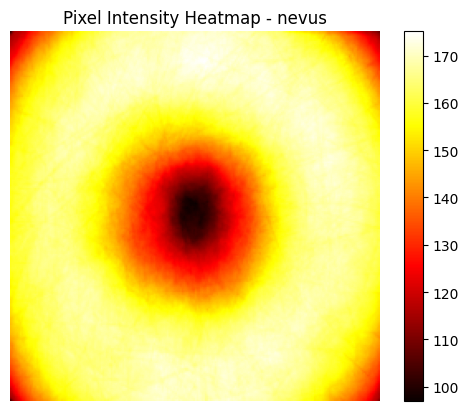

In [31]:
for cls in classes:
    acc_img = np.zeros((224,224))
    for img_path in random.sample(image_paths[cls], min(100,len(image_paths[cls]))):
        img = np.array(Image.open(img_path).convert("L").resize((224,224)))
        acc_img += img/100
    plt.imshow(acc_img, cmap='hot')
    plt.title(f"Pixel Intensity Heatmap - {cls}")
    plt.colorbar()
    plt.axis('off')
    plt.show()


### Summary Statistics per Class

In [32]:
for cls in classes:
    print(f"\nClass: {cls}")
    print(f"Image count: {len(image_paths[cls])}")
    print(f"Width: min {min([Image.open(p).width for p in image_paths[cls]])}, "
          f"max {max([Image.open(p).width for p in image_paths[cls]])}")
    print(f"Height: min {min([Image.open(p).height for p in image_paths[cls]])}, "
          f"max {max([Image.open(p).height for p in image_paths[cls]])}")
    print(f"Brightness: mean {np.mean(brightness_dict[cls]):.2f}, std {np.std(brightness_dict[cls]):.2f}")
    print(f"Contrast: mean {np.mean(contrast_dict[cls]):.2f}, std {np.std(contrast_dict[cls]):.2f}")



Class: melanoma_in_situ
Image count: 850
Width: min 224, max 224
Height: min 224, max 224
Brightness: mean 156.45, std 22.77
Contrast: mean 28.02, std 13.02

Class: melanoma_invasive
Image count: 797
Width: min 224, max 224
Height: min 224, max 224
Brightness: mean 150.94, std 25.12
Contrast: mean 31.56, std 15.98

Class: nevus
Image count: 800
Width: min 224, max 224
Height: min 224, max 224
Brightness: mean 160.19, std 23.72
Contrast: mean 33.96, std 15.15


### separate histograms per class

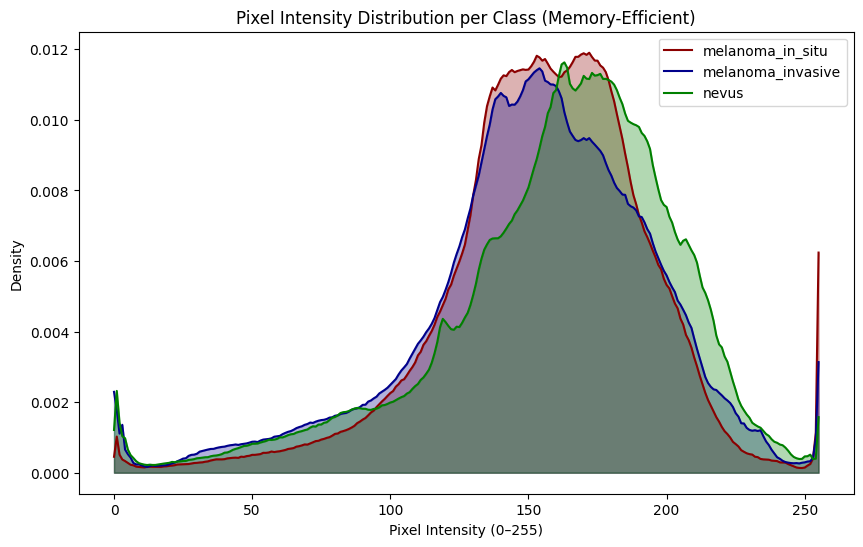

In [34]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# Function to compute histogram incrementally per class
def compute_class_hist(file_list, n=200, bins=256):
    hist = np.zeros(bins, dtype=np.float64)
    sample_imgs = random.sample(file_list, min(len(file_list), n))
    
    for path in sample_imgs:
        img = Image.open(path).convert("L")  # grayscale
        arr = np.array(img).ravel()
        h, _ = np.histogram(arr, bins=bins, range=(0,255))
        hist += h
    
    hist = hist / hist.sum()  # normalize to get density
    return hist

# Define colors per class for plotting
class_colors = {
    'melanoma_in_situ': 'darkred',
    'melanoma_invasive': 'darkblue',
    'nevus': 'green'
}

plt.figure(figsize=(10,6))

# Compute and plot per-class histograms
for cls in classes:
    hist = compute_class_hist(image_paths[cls], n=200)
    plt.plot(range(256), hist, color=class_colors[cls], label=cls)
    plt.fill_between(range(256), hist, alpha=0.3, color=class_colors[cls])

plt.title("Pixel Intensity Distribution per Class (Memory-Efficient)")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Density")
plt.legend()
plt.show()


### Check for Duplicates

In [39]:
duplicate_count = df['image_path'].duplicated().sum()
print(f"Duplicate files found: {duplicate_count}")


Duplicate files found: 0


### Average Pixel Intensity (Grayscale Analysis)

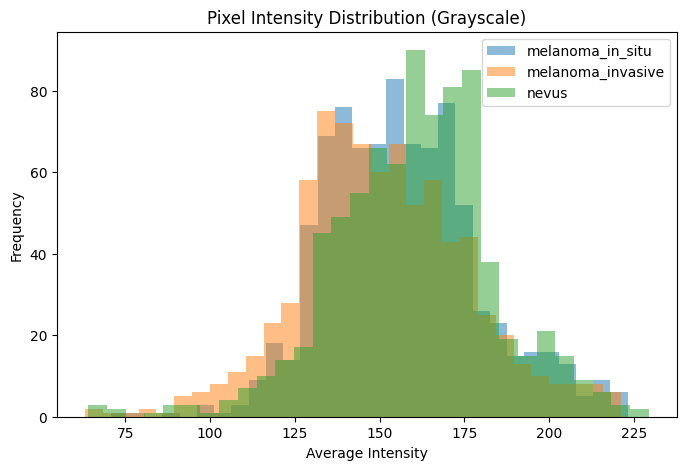

In [42]:
def avg_intensity(img_path):
    img = Image.open(img_path).convert("L")
    return np.mean(np.array(img))

df['avg_intensity'] = df['image_path'].apply(avg_intensity)

plt.figure(figsize=(8,5))
for cls in df['label'].unique():
    subset = df[df['label'] == cls]
    plt.hist(subset['avg_intensity'], bins=30, alpha=0.5, label=cls)
plt.legend()
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Average Intensity")
plt.ylabel("Frequency")
plt.show()


### Color Channel Mean Analysis

100%|██████████| 100/100 [00:00<00:00, 584.66it/s]


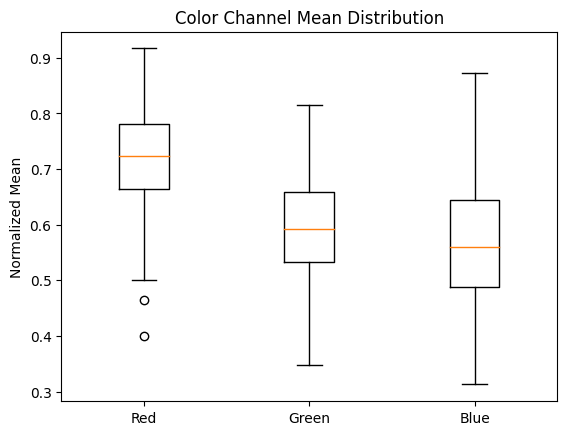

In [43]:
means = {'R': [], 'G': [], 'B': []}

for path in tqdm(df['image_path'].sample(100)):  # sample for speed
    img = np.array(Image.open(path).convert("RGB")) / 255.0
    means['R'].append(np.mean(img[:,:,0]))
    means['G'].append(np.mean(img[:,:,1]))
    means['B'].append(np.mean(img[:,:,2]))

plt.boxplot([means['R'], means['G'], means['B']], labels=['Red', 'Green', 'Blue'])
plt.title("Color Channel Mean Distribution")
plt.ylabel("Normalized Mean")
plt.show()


## Data Augmentation & Transformation

In [7]:

# --------------------- Transforms ---------------------
train_transforms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# # --------------------- Strong Augmentations ---------------------
# train_transforms = T.Compose([
#     # Geometric
#     T.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
#     T.RandomHorizontalFlip(p=0.5),
#     T.RandomVerticalFlip(p=0.5),
#     T.RandomRotation(degrees=45),
#     T.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),

#     # Color & Lighting
#     T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
#     T.RandomApply([T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.3),
#     T.RandomApply([T.RandomGrayscale(p=0.2)], p=0.3),

#     # Noise & Distortion
#     T.RandomPerspective(distortion_scale=0.4, p=0.3),
#     T.RandomApply([T.ElasticTransform(alpha=50.0)], p=0.3),

#     # Tensor Conversion + Normalization
#     T.ToTensor(),
#     T.RandomErasing(p=0.4, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
#     T.Normalize([0.485, 0.456, 0.406],
#                 [0.229, 0.224, 0.225]),
# ])

# val_transforms = T.Compose([
#     T.Resize(int(IMG_SIZE * 1.1)),
#     T.CenterCrop(IMG_SIZE),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406],
#                 [0.229, 0.224, 0.225]),
# ])


In [8]:
# train_transforms
# val_transforms

In [9]:

# --------------------- Stage 1: 3-class DeiT-base ---------------------
df_stage1 = build_dataframe(DATA_ROOT, LABELS_STAGE1)
train_df_s1, val_df_s1 = train_test_split(df_stage1, test_size=0.2, stratify=df_stage1['label_idx'], random_state=SEED)

# Weighted sampler for imbalance
counts = train_df_s1['label_idx'].value_counts().sort_index().values
class_weights = 1.0 / (counts + 1e-6)
samples_weight = train_df_s1['label_idx'].map(lambda x: class_weights[x]).values
sampler = WeightedRandomSampler(torch.DoubleTensor(samples_weight), num_samples=len(samples_weight), replacement=True)

train_ds_s1 = SkinDataset(train_df_s1, train_transforms)
val_ds_s1 = SkinDataset(val_df_s1, val_transforms)
train_loader_s1 = DataLoader(train_ds_s1, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader_s1 = DataLoader(val_ds_s1, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model_s1 = timm.create_model('deit_base_distilled_patch16_224', pretrained=True, num_classes=len(LABELS_STAGE1)).to(DEVICE)
criterion_s1 = nn.CrossEntropyLoss(weight=torch.tensor(class_weights,dtype=torch.float).to(DEVICE))
optimizer_s1 = torch.optim.AdamW(model_s1.parameters(), lr=3e-5)

In [10]:
df_stage1

,image_path,label,label_idx
0,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_invasive,2
1,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1
2,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1
3,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_invasive,2
4,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1
...,...,...,...
2442,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1
2443,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1
2444,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1
2445,/kaggle/input/melanoma-balanced-resized-verion...,melanoma_in_situ,1


In [11]:

# --------------------- Training & other importat Functions ---------------------

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss=0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item()) * imgs.size(0)
    return running_loss/len(loader.dataset)

def val_epoch(model, loader, criterion, device):
    model.eval()
    running_loss=0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())*imgs.size(0)
            all_preds.append(torch.softmax(outputs,dim=1).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return running_loss/len(loader.dataset), np.concatenate(all_labels), np.concatenate(all_preds)
    

# --------------------- Metrics Helper ---------------------
def compute_accuracy(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

def plot_learning_curves(train_losses, val_losses, title='Learning Curve'):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_true, y_probs, n_classes, class_names):
    plt.figure(figsize=(7,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_probs[:, i])
        auc_score = roc_auc_score((y_true==i).astype(int), y_probs[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC={auc_score:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()

def plot_precision_recall(y_true, y_probs, n_classes, class_names):
    plt.figure(figsize=(7,6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve((y_true==i).astype(int), y_probs[:, i])
        ap = average_precision_score((y_true==i).astype(int), y_probs[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]} (AP={ap:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


In [12]:

# --------------------- Stage 1 Training ---------------------

train_losses_s1, val_losses_s1 = [], []

for epoch in range(EPOCHS_STAGE1):
    train_loss = train_epoch(model_s1, train_loader_s1, criterion_s1, optimizer_s1, DEVICE)
    val_loss, y_true_s1, y_probs_s1 = val_epoch(model_s1, val_loader_s1, criterion_s1, DEVICE)
    y_pred_s1 = np.argmax(y_probs_s1, axis=1)
    train_losses_s1.append(train_loss)
    val_losses_s1.append(val_loss)
    print(f"Stage1 Epoch {epoch+1}/{EPOCHS_STAGE1} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

# --------------------- Stage 2: Binary EfficientNet-B2 ---------------------
df_stage2 = df_stage1[df_stage1['label'].isin(LABELS_STAGE2)].copy()
df_stage2['label_idx'] = df_stage2['label'].map({lbl:i for i,lbl in enumerate(LABELS_STAGE2)})
train_df_s2, val_df_s2 = train_test_split(df_stage2, test_size=0.2, stratify=df_stage2['label_idx'], random_state=SEED)

counts2 = train_df_s2['label_idx'].value_counts().sort_index().values
class_weights2 = 1.0 / (counts2 + 1e-6)
samples_weight2 = train_df_s2['label_idx'].map(lambda x: class_weights2[x]).values
sampler2 = WeightedRandomSampler(torch.DoubleTensor(samples_weight2), num_samples=len(samples_weight2), replacement=True)

train_ds_s2 = SkinDataset(train_df_s2, train_transforms)
val_ds_s2 = SkinDataset(val_df_s2, val_transforms)
train_loader_s2 = DataLoader(train_ds_s2, batch_size=BATCH_SIZE, sampler=sampler2, num_workers=2)
val_loader_s2 = DataLoader(val_ds_s2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model_s2 = timm.create_model('efficientnet_b2', pretrained=True, num_classes=len(LABELS_STAGE2)).to(DEVICE)
criterion_s2 = nn.CrossEntropyLoss(weight=torch.tensor(class_weights2,dtype=torch.float).to(DEVICE))
optimizer_s2 = torch.optim.AdamW(model_s2.parameters(), lr=3e-5)

# --------------------- Stage 2 Training ---------------------

train_losses_s2, val_losses_s2 = [], []

for epoch in range(EPOCHS_STAGE2):
    train_loss = train_epoch(model_s2, train_loader_s2, criterion_s2, optimizer_s2, DEVICE)
    val_loss, y_true_s2, y_probs_s2 = val_epoch(model_s2, val_loader_s2, criterion_s2, DEVICE)
    y_pred_s2 = np.argmax(y_probs_s2, axis=1)
    train_losses_s2.append(train_loss)
    val_losses_s2.append(val_loss)
    print(f"Stage2 Epoch {epoch+1}/{EPOCHS_STAGE2} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")
    

Stage1 Epoch 1/10 train_loss=0.9076 val_loss=0.8405
Stage1 Epoch 2/10 train_loss=0.7348 val_loss=0.8435
Stage1 Epoch 3/10 train_loss=0.6411 val_loss=0.7758
Stage1 Epoch 4/10 train_loss=0.5513 val_loss=0.7378
Stage1 Epoch 5/10 train_loss=0.4629 val_loss=0.7576
Stage1 Epoch 6/10 train_loss=0.3923 val_loss=0.7703
Stage1 Epoch 7/10 train_loss=0.2939 val_loss=0.7678
Stage1 Epoch 8/10 train_loss=0.2683 val_loss=0.7963
Stage1 Epoch 9/10 train_loss=0.1974 val_loss=0.8243
Stage1 Epoch 10/10 train_loss=0.1718 val_loss=0.8588
Stage2 Epoch 1/40 train_loss=2.3753 val_loss=2.2894
Stage2 Epoch 2/40 train_loss=1.5925 val_loss=2.0620
Stage2 Epoch 3/40 train_loss=1.4184 val_loss=1.8280
Stage2 Epoch 4/40 train_loss=1.2890 val_loss=1.7038
Stage2 Epoch 5/40 train_loss=1.1146 val_loss=1.5874
Stage2 Epoch 6/40 train_loss=0.9586 val_loss=1.6145
Stage2 Epoch 7/40 train_loss=1.0401 val_loss=1.6083
Stage2 Epoch 8/40 train_loss=0.9038 val_loss=1.4465
Stage2 Epoch 9/40 train_loss=0.8105 val_loss=1.4058
Stage2 Epoc

In [13]:

# --------------------- Ensemble Inference ---------------------
def ensemble_predict(img_path):
    img = Image.open(img_path).convert('RGB')
    t_img = val_transforms(img).unsqueeze(0).to(DEVICE)
    model_s1.eval(); model_s2.eval()
    with torch.no_grad():
        out1 = torch.softmax(model_s1(t_img), dim=1).cpu().numpy()[0]
        stage1_label = np.argmax(out1)
        if stage1_label == LABELS_STAGE1.index('nevus'):
            return 'nevus', out1
        else:
            out2 = torch.softmax(model_s2(t_img), dim=1).cpu().numpy()[0]
            stage2_label = np.argmax(out2)
            final_label = LABELS_STAGE2[stage2_label]
            return final_label, out2


In [14]:
### Example
ensemble_predict("/kaggle/input/melanoma-balanced-resized-verion-04/melanoma_balanced_resized_verion 04/melanoma_invasive/0003.jpg")

('melanoma_invasive', array([2.2162696e-06, 9.9999774e-01], dtype=float32))


==== MODEL EVALUATION METRICS ====


Classification Report (Ensemble):
                   precision    recall  f1-score   support

            nevus       0.79      0.84      0.81       170
 melanoma_in_situ       0.78      0.82      0.80       160
melanoma_invasive       0.77      0.68      0.72       160

         accuracy                           0.78       490
        macro avg       0.78      0.78      0.78       490
     weighted avg       0.78      0.78      0.78       490



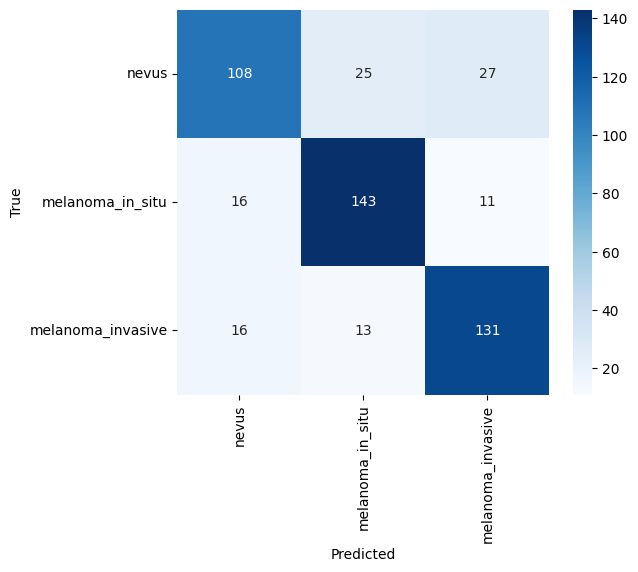

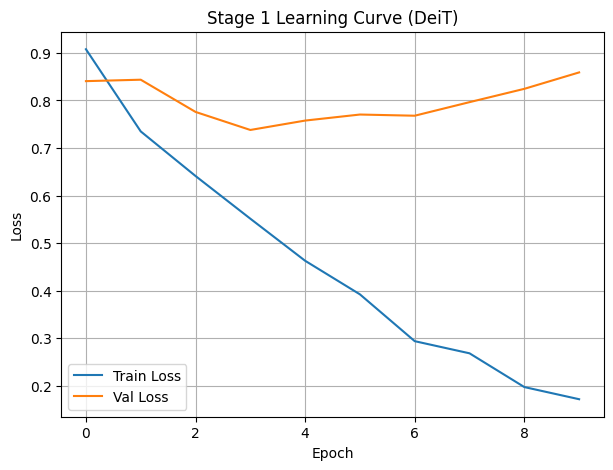

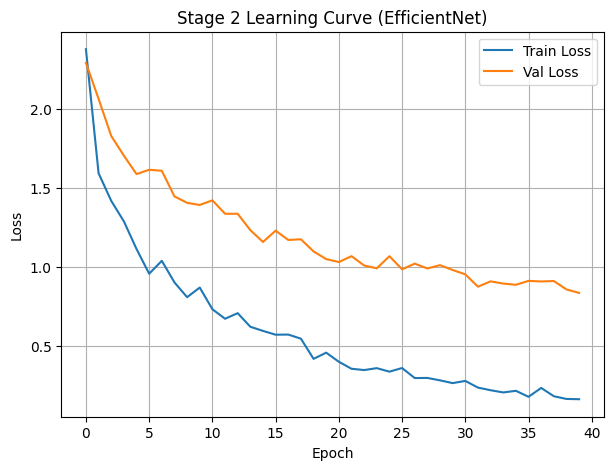

Test Accuracy (Ensemble): 77.96%



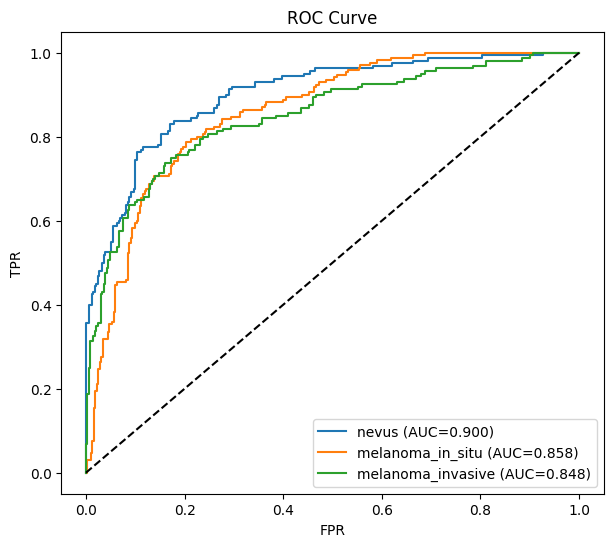

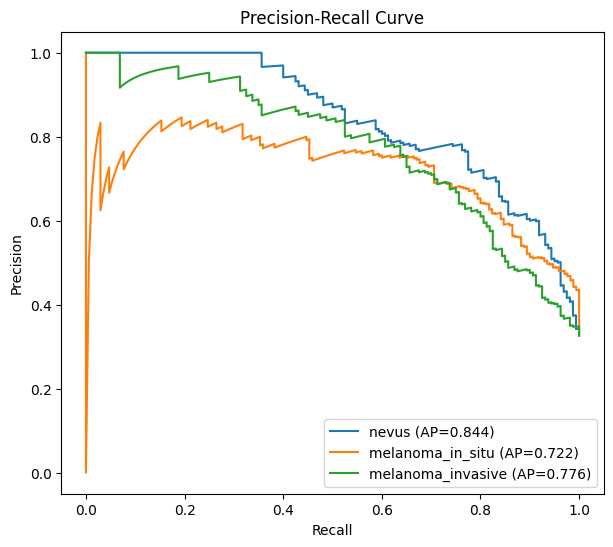

AUC (Stage 1 Multi-Class): 0.8688



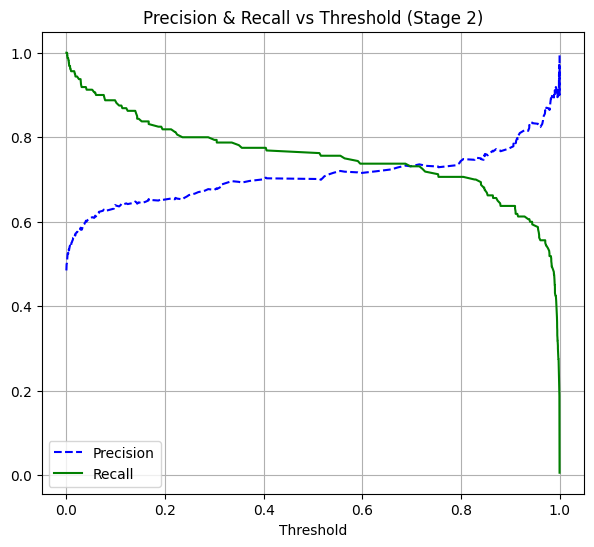


Generating Grad-CAM heatmap (EfficientNet)...


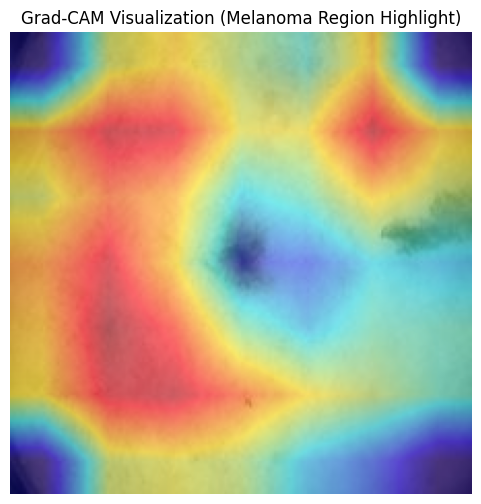

In [17]:
# ======================================================
#                 MODEL EVALUATION
# ======================================================
# -------------------- Grad-CAM Imports --------------------
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image



print("\n==== MODEL EVALUATION METRICS ====\n")

# --------------------- Evaluation ---------------------
all_labels, all_preds = [], []
for idx, row in val_df_s1.iterrows():
    pred_label, _ = ensemble_predict(row['image_path'])
    all_labels.append(row['label'])
    all_preds.append(pred_label)

print("\nClassification Report (Ensemble):")
print(classification_report(all_labels, all_preds, target_names=LABELS_STAGE1))

cm = confusion_matrix(all_labels, all_preds, labels=LABELS_STAGE1)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=LABELS_STAGE1, yticklabels=LABELS_STAGE1, cmap='Blues')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()



# 1. Learning Curves
plot_learning_curves(train_losses_s1, val_losses_s1, title='Stage 1 Learning Curve (DeiT)')
plot_learning_curves(train_losses_s2, val_losses_s2, title='Stage 2 Learning Curve (EfficientNet)')

# 2. Test Accuracy
acc = compute_accuracy(all_labels, all_preds)
print(f"Test Accuracy (Ensemble): {acc*100:.2f}%\n")

# 3. ROC Curve
_, _, y_probs_full = val_epoch(model_s1, val_loader_s1, criterion_s1, DEVICE)
plot_roc_curve(y_true_s1, y_probs_s1, len(LABELS_STAGE1), LABELS_STAGE1)

# 4. Precision-Recall Curve
plot_precision_recall(y_true_s1, y_probs_s1, len(LABELS_STAGE1), LABELS_STAGE1)

# 5. AUC Score
auc = roc_auc_score(y_true_s1, y_probs_s1, multi_class='ovr')
print(f"AUC (Stage 1 Multi-Class): {auc:.4f}\n")

# 6. Precision vs Recall vs Threshold (Stage 2 binary)
precision, recall, thresholds = precision_recall_curve(y_true_s2, y_probs_s2[:,1])
plt.figure(figsize=(7,6))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision & Recall vs Threshold (Stage 2)")
plt.legend()
plt.grid(True)
plt.show()


# 8. Grad-CAM Visualization (Stage 2 Example)
print("\nGenerating Grad-CAM heatmap (EfficientNet)...")

# Choose last convolutional layer (better feature localization)
try:
    target_layers = [model_s2.blocks[-1][-1].conv_pwl]
except Exception:
    target_layers = [model_s2.conv_head]

#  Move model to CUDA explicitly
model_s2 = model_s2.to(DEVICE)
model_s2.eval()

#  Initialize GradCAM
cam = GradCAM(model=model_s2, target_layers=target_layers)

# Load image
img_path = val_df_s2.iloc[0]['image_path']
pil_img = Image.open(img_path).convert('RGB')
rgb_img = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE))) / 255.0

# Apply your validation transforms
input_tensor = val_transforms(pil_img).unsqueeze(0).to(DEVICE)

# Compute GradCAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])[0, :]

# Overlay heatmap on image
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display
plt.figure(figsize=(6,6))
plt.imshow(cam_image)
plt.title('Grad-CAM Visualization (Melanoma Region Highlight)', fontsize=12)
plt.axis('off')
plt.show()
